In [89]:
!pip install nfl_data_py


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import nfl_data_py as nfl
import os

# Gather Training and Testing Data

In [91]:
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [92]:
np.random.seed(1587)

train_data = pd.read_excel("nfl_weeks1_6_2015_2023_train.xlsx")
test_data = pd.read_excel("test2024.xlsx")

# EDA

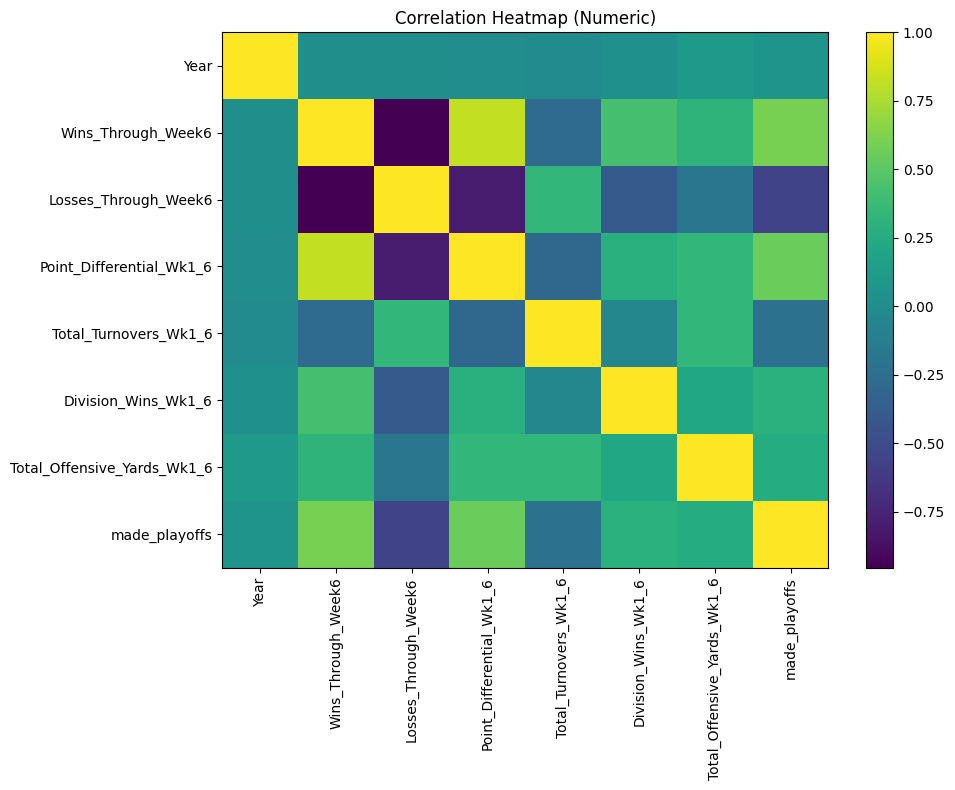

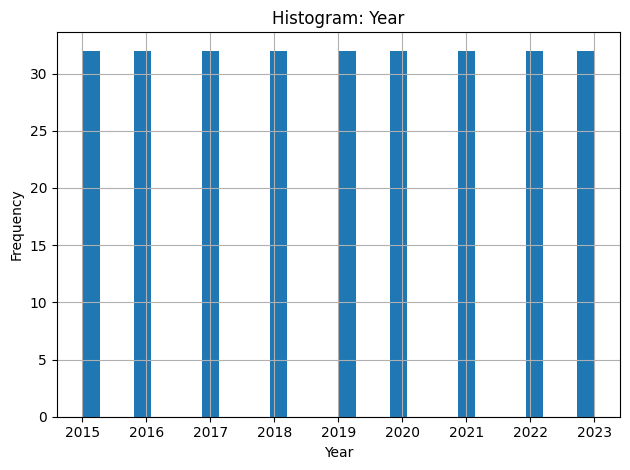

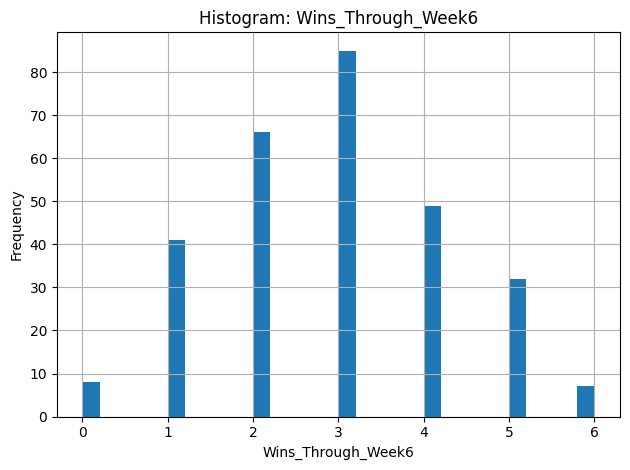

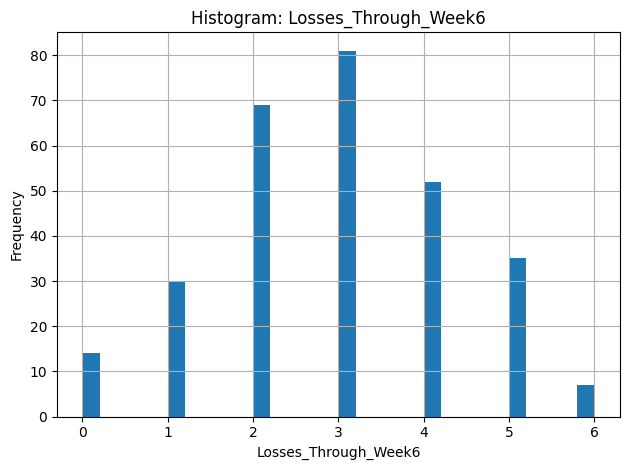

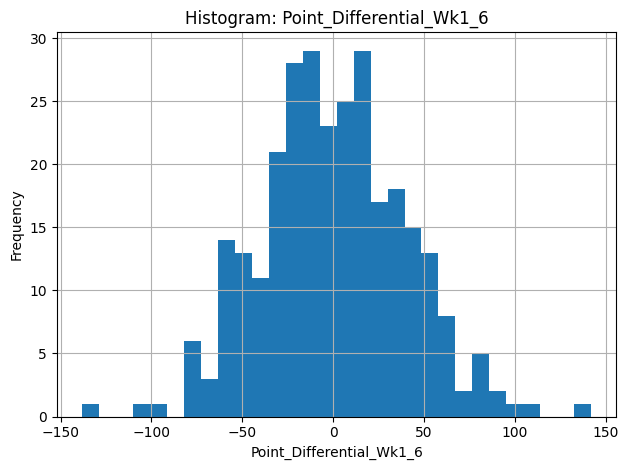

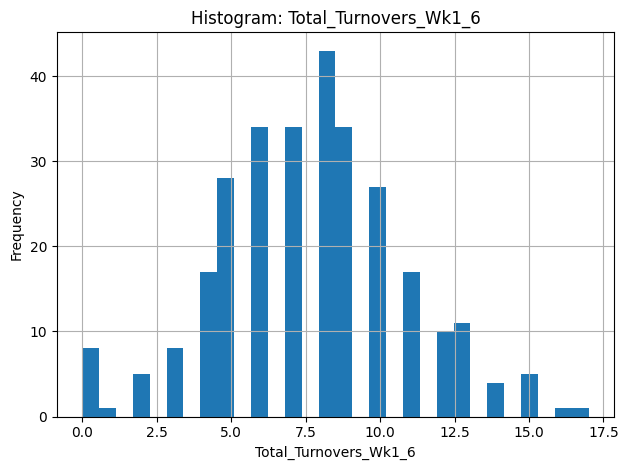

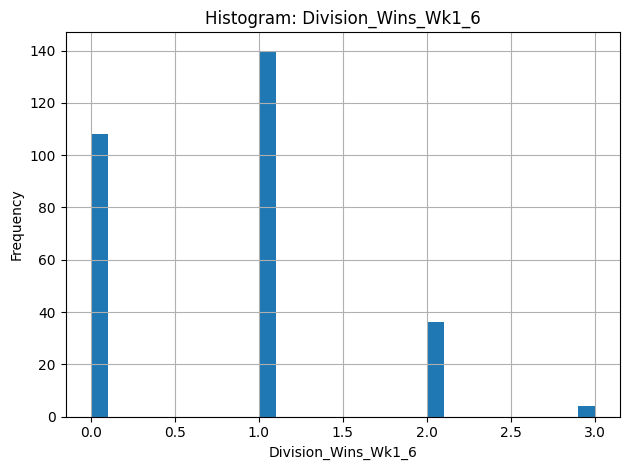

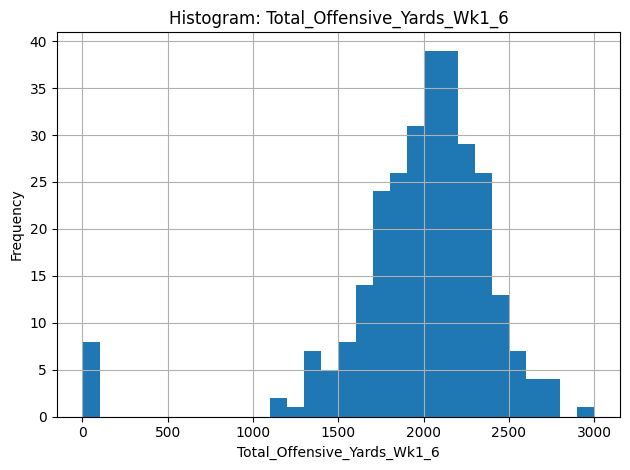

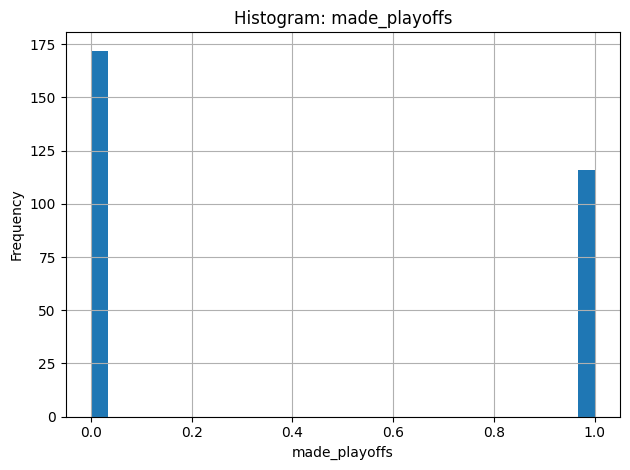

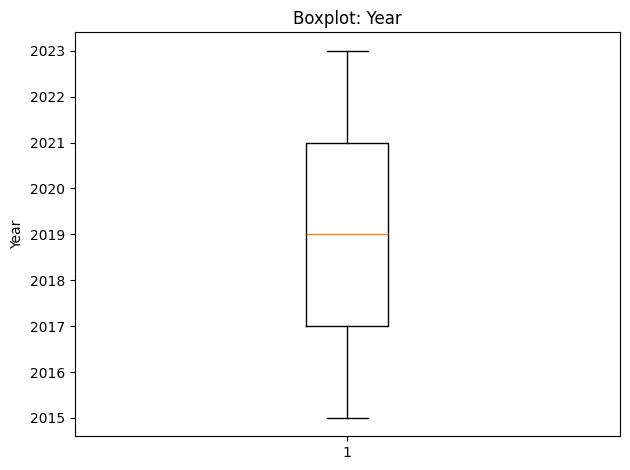

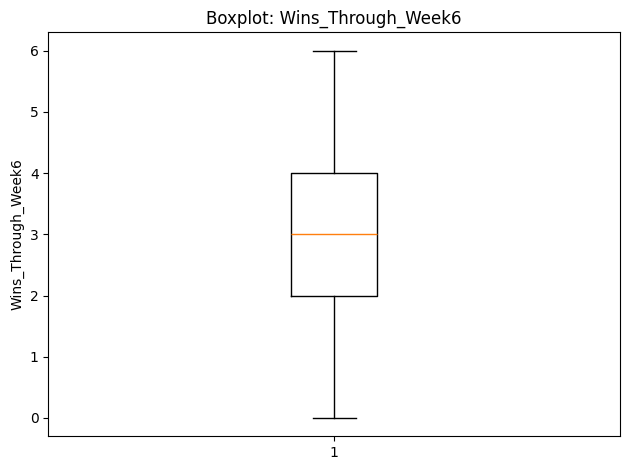

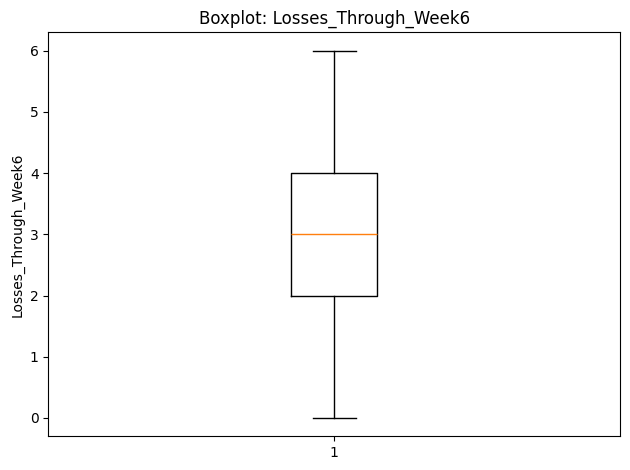

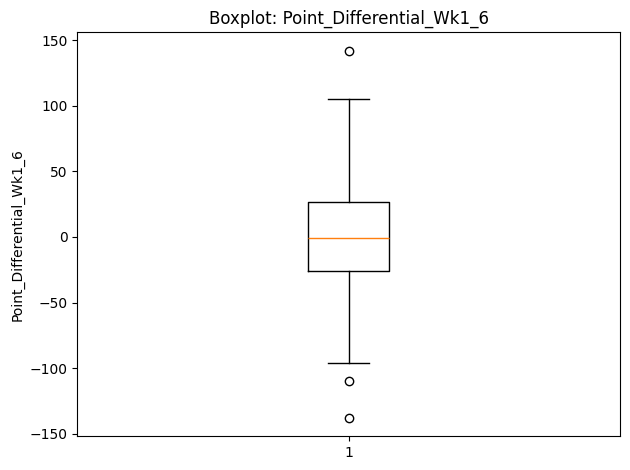

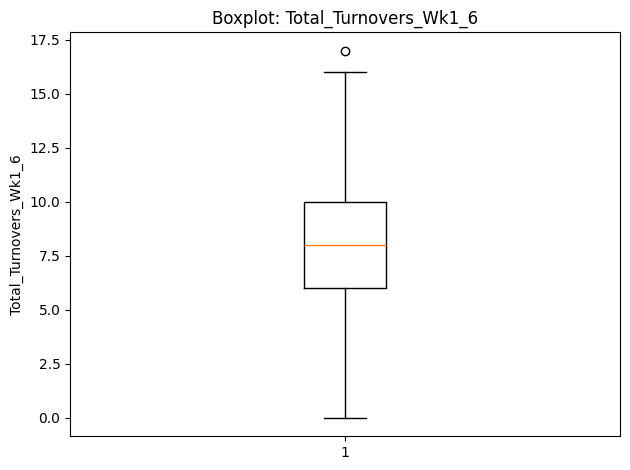

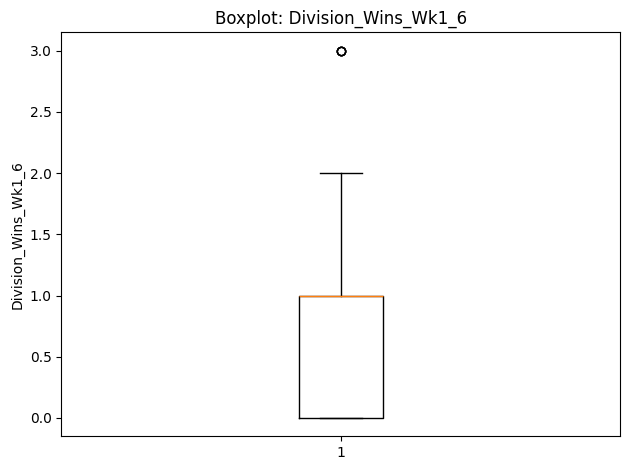

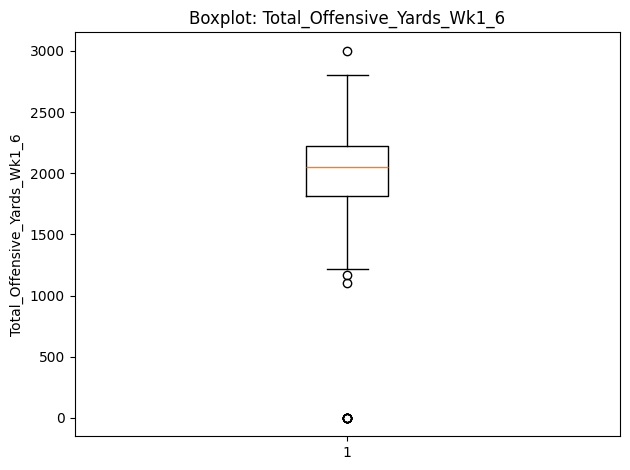

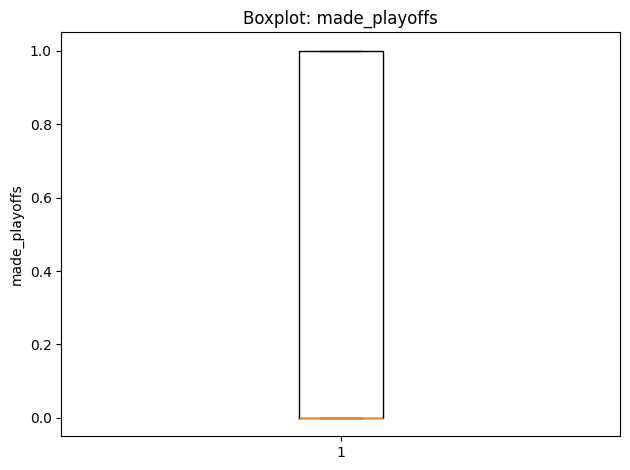

In [93]:
# EDA for /mnt/data/nfl_weeks1_6_2015_2023_train.xlsx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

file_path = Path("nfl_weeks1_6_2015_2023_train.xlsx")

# 1) Load
df = pd.read_excel(file_path)



# 2) Column info
dtypes = df.dtypes.astype(str)
non_null_counts = df.notna().sum()
null_counts = df.isna().sum()
null_pct = (null_counts/len(df)*100).round(2)

col_info = pd.DataFrame({
    "dtype": dtypes,
    "non_null": non_null_counts,
    "nulls": null_counts,
    "null_%": null_pct
}).sort_index()


# 3) Numeric stats
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_stats = df[numeric_cols].describe().T

# 4) Categorical / low-cardinality summary
cat_like_cols = list(df.select_dtypes(include=["object","bool"]).columns)
low_card_num = [c for c in numeric_cols if df[c].nunique(dropna=True) <= 12]
cat_like_cols += [c for c in low_card_num if c not in cat_like_cols]

cat_summary_frames = []
for c in cat_like_cols:
    vc = df[c].value_counts(dropna=False).head(25)
    top_val = vc.index[0] if len(vc) else np.nan
    top_cnt = int(vc.iloc[0]) if len(vc) else np.nan
    nunique = df[c].nunique(dropna=True)
    cat_summary_frames.append(pd.DataFrame({
        "column":[c],
        "nunique":[nunique],
        "top":[top_val],
        "top_count":[top_cnt]
    }))

if cat_summary_frames:
    cat_summary = pd.concat(cat_summary_frames, ignore_index=True).sort_values("column")
else:
    cat_summary = pd.DataFrame(columns=["column","nunique","top","top_count"])


# 5) Missingness detail
top_missing = col_info.sort_values("null_%", ascending=False).head(20)

# 6) Correlation matrix
if len(numeric_cols) >= 2:
    corr = df[numeric_cols].corr(numeric_only=True)

    plt.figure(figsize=(10, 8))
    plt.imshow(corr, aspect='auto')
    plt.title("Correlation Heatmap (Numeric)")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

# 7) Histograms for numeric columns
for col in numeric_cols:
    try:
        plt.figure()
        df[col].dropna().hist(bins=30)
        plt.title(f"Histogram: {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()
    except Exception:
        pass

# 8) Boxplots for numeric columns
for col in numeric_cols:
    try:
        plt.figure()
        plt.boxplot(df[col].dropna().values, vert=True)
        plt.title(f"Boxplot: {col}")
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()
    except Exception:
        pass



# Train and Fit model

In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [95]:
X_train = train_data[['Wins_Through_Week6', 'Losses_Through_Week6', 'Point_Differential_Wk1_6', 'Total_Turnovers_Wk1_6', 'Division_Wins_Wk1_6', 'Total_Offensive_Yards_Wk1_6']]
y_train = train_data['made_playoffs']

X_test= test_data[['Wins_Through_Week6', 'Losses_Through_Week6', 'Point_Differential_Wk1_6', 'Total_Turnovers_Wk1_6', 'Division_Wins_Wk1_6', 'Total_Offensive_Yards_Wk1_6']]
y_test = test_data['made_playoffs']

In [96]:
lr_model = LogisticRegression(fit_intercept=True, solver='lbfgs', max_iter=1000)

lr_model.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [97]:
# Add intercept manually to match scikit-learn
X2 = sm.add_constant(X_test)

# Get predicted probabilities
pred_probs = lr_model.predict_proba(X_test)[:, 1]

# Calculate the variance-covariance matrix
V = np.diagflat(pred_probs * (1 - pred_probs))
cov_matrix = np.linalg.inv(X2.T @ V @ X2)

# Standard errors
standard_errors = np.sqrt(np.diag(cov_matrix))


In [98]:
from scipy import stats

# Combine intercept and coefficients
params = np.concatenate([lr_model.intercept_, lr_model.coef_.flatten()])

# z-scores
z_scores = params / standard_errors

# two-tailed p-values
p_values = [2 * (1 - stats.norm.cdf(np.abs(z))) for z in z_scores]

In [99]:
ci_lower = params - 1.96 * standard_errors
ci_upper = params + 1.96 * standard_errors

In [100]:
summary = pd.DataFrame({
    "Coefficient": params,
    "Std. Error": standard_errors,
    "z-score": z_scores,
    "p-value": p_values,
    "95% CI Lower": ci_lower,
    "95% CI Upper": ci_upper
}, index=["Intercept"] + list(X_test.columns))

print(summary)

                             Coefficient  Std. Error   z-score   p-value  \
Intercept                      -3.485391    7.198750 -0.484166  0.628268   
Wins_Through_Week6              0.779185    1.777003  0.438483  0.661036   
Losses_Through_Week6           -0.017132    1.423924 -0.012031  0.990401   
Point_Differential_Wk1_6        0.016867    0.024979  0.675254  0.499514   
Total_Turnovers_Wk1_6          -0.099342    0.235749 -0.421387  0.673472   
Division_Wins_Wk1_6             0.308150    0.658360  0.468057  0.639744   
Total_Offensive_Yards_Wk1_6     0.000604    0.001912  0.316010  0.751995   

                             95% CI Lower  95% CI Upper  
Intercept                      -17.594941     10.624159  
Wins_Through_Week6              -2.703740      4.262111  
Losses_Through_Week6            -2.808023      2.773760  
Point_Differential_Wk1_6        -0.032091      0.065826  
Total_Turnovers_Wk1_6           -0.561410      0.362727  
Division_Wins_Wk1_6             -0.982236  

| Variable                        | Coefficient (B) | Odds Ratio (Exp(B))                                                                                                                                               
| ------------------------------- | --------------- | ------------------- 
| **Intercept**                   | -3.485          | —                                                                                                                          |
| **Wins_Through_Week6**          | 0.779           | **2.18**            
| **Losses_Through_Week6**        | -0.017          | **0.98**                                                        
| **Point_Differential_Wk1_6**    | 0.0169          | **1.02**            
| **Total_Turnovers_Wk1_6**       | -0.099          | **0.91**            
| **Division_Wins_Wk1_6**         | 0.308           | **1.36**               
| **Total_Offensive_Yards_Wk1_6** | 0.000604        | **1.0006**          





In [101]:
y_pred = lr_model.predict(X_test)

custom_threshold = 0.62
y_pred_custom = (pred_probs >= custom_threshold).astype(int)

test_data['predicted_made_playoffs'] = y_pred_custom
test_data['predicted_probability'] = pred_probs


mae = mean_absolute_error(y_test, y_pred_custom)
mse = mean_squared_error(y_test, y_pred_custom)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_custom)
print(f'Mean Absolute Error: {mae:.4f}')
print(f'Mean Squared Error: {mse:.4f}')
print(f'Root Mean Squared Error: {rmse:.4f}')
print(f'R-squared: {r2:.4f}')





Mean Absolute Error: 0.1562
Mean Squared Error: 0.1562
Root Mean Squared Error: 0.3953
R-squared: 0.3651


| Metric                             | Value  | Meaning                                                                                                                                                                                                           |
| ---------------------------------- | ------ | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Mean Absolute Error (MAE)**      | 0.1562 | On average, the predictions are **off by about 0.156** (15.6 percentage points) from the true target values. This measures average absolute deviation — lower is better.                                         |
| **Mean Squared Error (MSE)**       | 0.1562 | The average of squared errors between predicted and actual values. The same value as MAE here suggests moderate, consistent prediction error without large outliers.                                              |
| **Root Mean Squared Error (RMSE)** | 0.3953 | The square root of MSE. This is the **average magnitude of prediction error**, in the same units as the target. So predictions are typically off by about **0.395** on a 0–1 scale.                               |
| **R-squared (R²)**                 | 0.3651 | The model explains **~36.5% of the variance** in the outcome. That means your predictors collectively account for over a third of the variation — modest but meaningful for sports data, which tends to be noisy. |


In [102]:
from sklearn.metrics import(

    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    classification_report

)

In [103]:
y_true = test_data['made_playoffs'].astype(int).to_numpy()
y_scores = test_data['predicted_made_playoffs'].to_numpy()


In [104]:
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

rows = []

for t in thresholds:
    y_pred = (y_scores >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    precision = precision_score(y_true, y_pred) # total predicted positives that were actually positive
    rec = recall_score(y_true, y_pred) # total actual positives that were correctly identified
    f1 = f1_score(y_true, y_pred) # harmonic mean of precision and recall
    acc = (tp + tn) / (tp + tn + fp + fn)

    rows.append({
        'threshold': t,
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'precision': precision,
        'recall': rec,
        'f1_score': f1,
        'accuracy': acc

})

In [105]:
thr_table = pd.DataFrame(rows)

thr_table




cm = confusion_matrix(y_true, y_pred_custom)


print(cm) # FP top right, FN bottom left, TP bottom right, TN top left



[[16  2]
 [ 3 11]]


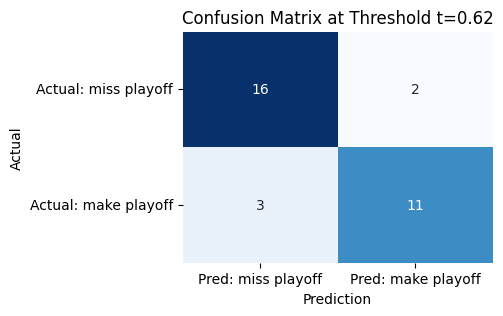

In [106]:
plt.figure(figsize=(4, 3))

sns.heatmap(cm, annot=True, fmt='d', cbar = False,
            xticklabels=['Pred: miss playoff', 'Pred: make playoff'],
            yticklabels=['Actual: miss playoff', 'Actual: make playoff'],
            cmap='Blues')

plt.title(f'Confusion Matrix at Threshold t=0.62')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

|                          | Predicted: Miss Playoff | Predicted: Make Playoff |
| ------------------------ | ----------------------- | ----------------------- |
| **Actual: Miss Playoff** | **16** (True Negatives) | **2** (False Positives) |
| **Actual: Make Playoff** | **3** (False Negatives) | **11** (True Positives) |


So, out of 32 teams:

27 (16 + 11) were correctly classified → overall accuracy ≈ 84%.

5 teams (2 + 3) were misclassified.

The goal is to eliminate false positives because that error is the worst.


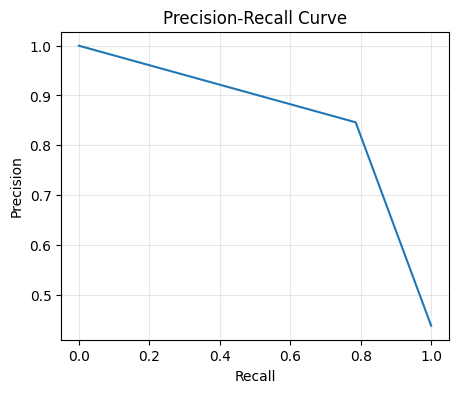

In [107]:
precision, rec, pr_thr = precision_recall_curve(y_true, y_scores)

plt.figure(figsize=(5, 4))
plt.plot(rec, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True, alpha=0.3)
plt.show()


You can choose your decision threshold based on your business or analytical goal:

If you want to minimize false playoff predictions, use a higher threshold (0.65–0.7).

If you want to catch every playoff team, use a slightly lower threshold (0.55–0.6).


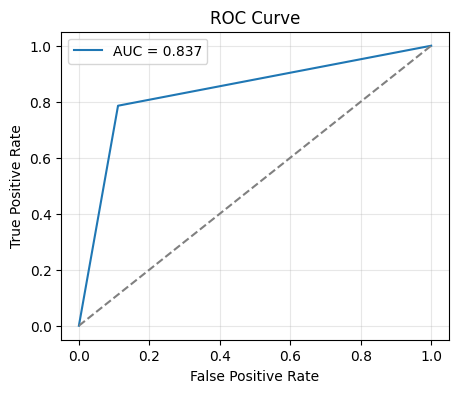

In [108]:
fpr, tpr, roc_thr = roc_curve(y_true, y_scores)
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label = f'AUC = {roc_auc_score(y_true, y_scores):.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [109]:
print(classification_report(y_true, y_pred_05, target_names=['miss playoff', 'make playoff']))

              precision    recall  f1-score   support

miss playoff       0.84      0.89      0.86        18
make playoff       0.85      0.79      0.81        14

    accuracy                           0.84        32
   macro avg       0.84      0.84      0.84        32
weighted avg       0.84      0.84      0.84        32



| Metric                   | Miss Playoff | Make Playoff | Meaning                                                                                                                                                       |
| ------------------------ | ------------ | ------------ | ------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Precision**            | 0.84         | 0.85         | When the model predicts a team will (or won’t) make the playoffs, it’s correct ≈ 84–85% of the time.                                                          |
| **Recall (Sensitivity)** | 0.89         | 0.79         | It identifies 89% of the actual non-playoff teams and 79% of the actual playoff teams correctly.                                                              |
| **F1-Score**             | 0.86         | 0.81         | Harmonic mean of precision & recall → balanced performance across both classes.                                                                               |
| **Accuracy**             | —            | —            | **0.84** overall → strong given small dataset.                                                                                                                |
| **AUC = 0.837**         | —            | —            | The model can correctly rank a random playoff team above a random non-playoff team ≈ 83% of the time → strong discrimination.. |


MCC=(11+2)(11+3)(16+2)(16+3)
​(11×16)−(2×3)​ = 0.68

MCC of 0.68 indicates a strong, well-balanced model — it’s performing consistently across both classes (not biased toward playoff or non-playoff teams).

In [110]:
train_data

,Year,Team,Wins_Through_Week6,Losses_Through_Week6,Point_Differential_Wk1_6,Total_Turnovers_Wk1_6,Division_Wins_Wk1_6,Total_Offensive_Yards_Wk1_6,made_playoffs
0,2015,ARI,4,2,88,9,1,2446,1
1,2015,ATL,5,1,40,8,0,2452,0
2,2015,BAL,1,5,-19,9,1,2217,0
3,2015,BUF,3,3,6,7,1,2018,0
4,2015,CAR,5,0,41,5,2,1678,1
...,...,...,...,...,...,...,...,...,...
283,2023,SEA,3,2,16,3,0,1669,0
284,2023,SF,5,1,97,3,1,2238,1
285,2023,TB,3,2,2,4,1,1467,1
286,2023,TEN,2,4,-13,6,0,1703,0


In [111]:
test_data

,Year,Team,Wins_Through_Week6,Losses_Through_Week6,Point_Differential_Wk1_6,Total_Turnovers_Wk1_6,Division_Wins_Wk1_6,Total_Offensive_Yards_Wk1_6,made_playoffs,predicted_made_playoffs,predicted_probability
0,2024,ARI,2,4,-30,8,1,2001,0,0,0.144396
1,2024,ATL,4,2,14,8,3,2220,0,1,0.786531
2,2024,BAL,4,2,28,5,1,2702,1,1,0.819536
3,2024,BUF,4,2,39,2,2,1866,1,1,0.858131
4,2024,CAR,1,5,-100,11,0,1794,0,0,0.011124
5,2024,CHI,4,2,47,7,0,1822,0,1,0.688947
6,2024,CIN,2,4,5,5,0,2103,0,0,0.242797
7,2024,CLE,1,5,-46,6,0,1444,0,0,0.035867
8,2024,DAL,3,3,-42,11,1,2021,0,0,0.186748
9,2024,DEN,3,3,16,10,1,1679,1,0,0.354283


In [112]:
test_data['predicted_made_playoffs'].value_counts()

0    19
1    13
Name: predicted_made_playoffs, dtype: int64

In [113]:
inference_data = pd.read_excel("inference2025.xlsx")

In [114]:
inference_data.head()


,Year,Team,Wins_Through_Week6,Losses_Through_Week6,Point_Differential_Wk1_6,Total_Turnovers_Wk1_6,Division_Wins_Wk1_6,Total_Offensive_Yards_Wk1_6
0,2025,ARI,2,4,3,7,0,1844
1,2025,ATL,3,2,0,7,0,1900
2,2025,BAL,1,5,-50,10,1,1859
3,2025,BUF,4,2,30,6,2,2282
4,2025,CAR,3,3,-14,8,1,1994


In [115]:
inference_data.columns

Index(['Year', 'Team', 'Wins_Through_Week6', 'Losses_Through_Week6',
       'Point_Differential_Wk1_6', 'Total_Turnovers_Wk1_6',
       'Division_Wins_Wk1_6', 'Total_Offensive_Yards_Wk1_6'],
      dtype='object')

In [116]:
# Select only the features used for training
inference_features = inference_data[['Wins_Through_Week6', 'Losses_Through_Week6', 'Point_Differential_Wk1_6', 'Total_Turnovers_Wk1_6', 'Division_Wins_Wk1_6', 'Total_Offensive_Yards_Wk1_6']]

# Make predictions using the trained model
inference_preds = lr_model.predict(inference_features)

# You can also get the probabilities of making the playoffs
inference_prob_preds = lr_model.predict_proba(inference_features)[:, 1]

# Add the predictions and probabilities back to the inference_data DataFrame
inference_data['predicted_made_playoffs'] = inference_preds
inference_data['predicted_probability'] = inference_prob_preds

display(inference_data)

,Year,Team,Wins_Through_Week6,Losses_Through_Week6,Point_Differential_Wk1_6,Total_Turnovers_Wk1_6,Division_Wins_Wk1_6,Total_Offensive_Yards_Wk1_6,predicted_made_playoffs,predicted_probability
0,2025,ARI,2,4,3,7,0,1844,0,0.178536
1,2025,ATL,3,2,0,7,0,1900,0,0.325279
2,2025,BAL,1,5,-50,10,1,1859,0,0.039264
3,2025,BUF,4,2,30,6,2,2282,1,0.817874
4,2025,CAR,3,3,-14,8,1,1994,0,0.327990
5,2025,CHI,3,2,-15,4,0,1698,0,0.308608
6,2025,CIN,2,4,-80,11,1,1414,0,0.036430
7,2025,CLE,1,5,-64,8,0,1690,0,0.025454
8,2025,DAL,2,4,-6,6,1,2329,0,0.273369
9,2025,DEN,4,2,35,6,0,2032,1,0.694025


In [117]:
inference_data['predicted_made_playoffs'].value_counts()

0    16
1    16
Name: predicted_made_playoffs, dtype: int64

In [141]:
import matplotlib.cm as cm


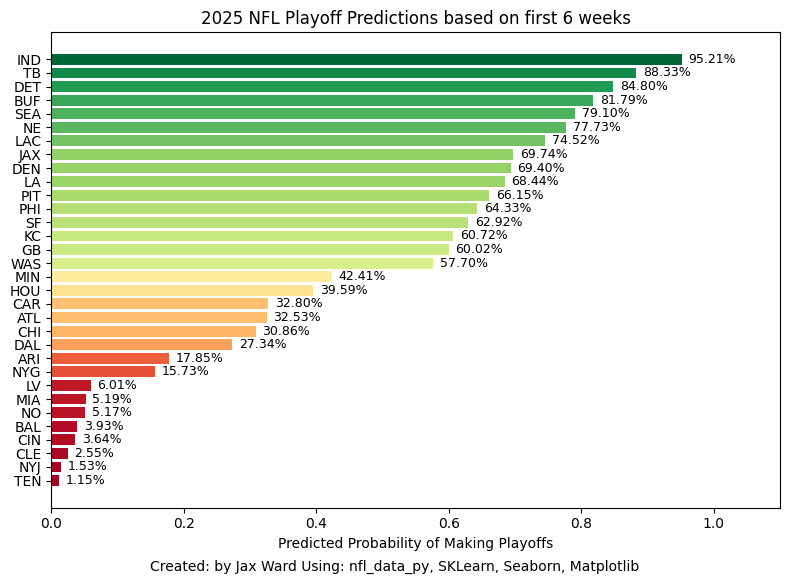

In [149]:
sorted_data = inference_data.sort_values(by="predicted_probability", ascending=False)

norm = plt.Normalize(sorted_data["predicted_probability"].min(),
                     sorted_data["predicted_probability"].max())

colors = cm.RdYlGn(norm(sorted_data["predicted_probability"]))


plt.figure(figsize=(8,6))
plt.barh(sorted_data["Team"], sorted_data["predicted_probability"], color=colors)
plt.xlabel("Predicted Probability of Making Playoffs")
plt.suptitle("Created: by Jax Ward Using: nfl_data_py, SKLearn, Seaborn, Matplotlib", fontsize=10, y=0.01, color='black')
plt.title("2025 NFL Playoff Predictions based on first 6 weeks")
plt.xlim(0, 1)

for index, value in enumerate(sorted_data["predicted_probability"]):
    plt.text(value + 0.01, index, f"{value:.2%}", va='center', fontsize=9)

plt.xlim(0, 1.1)
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()



In [156]:
division_map = {
    # AFC East
    "BUF": "AFC East",
    "MIA": "AFC East",
    "NE": "AFC East",
    "NYJ": "AFC East",

    # AFC North
    "BAL": "AFC North",
    "CIN": "AFC North",
    "CLE": "AFC North",
    "PIT": "AFC North",

    # AFC South
    "HOU": "AFC South",
    "IND": "AFC South",
    "JAX": "AFC South",
    "TEN": "AFC South",

    # AFC West
    "DEN": "AFC West",
    "KC": "AFC West",
    "LV": "AFC West",
    "LAC": "AFC West",

    # NFC East
    "DAL": "NFC East",
    "NYG": "NFC East",
    "PHI": "NFC East",
    "WAS": "NFC East",

    # NFC North
    "CHI": "NFC North",
    "DET": "NFC North",
    "GB": "NFC North",
    "MIN": "NFC North",

    # NFC South
    "ATL": "NFC South",
    "CAR": "NFC South",
    "NO": "NFC South",
    "TB": "NFC South",

    # NFC West
    "ARI": "NFC West",
    "LA": "NFC West",
    "SF": "NFC West",
    "SEA": "NFC West"
}

# Add Division and Conference columns
inference_data["Division"] = inference_data["Team"].map(division_map)
inference_data["Conference"] = inference_data["Division"].apply(lambda x: x.split()[0] if pd.notnull(x) else None)



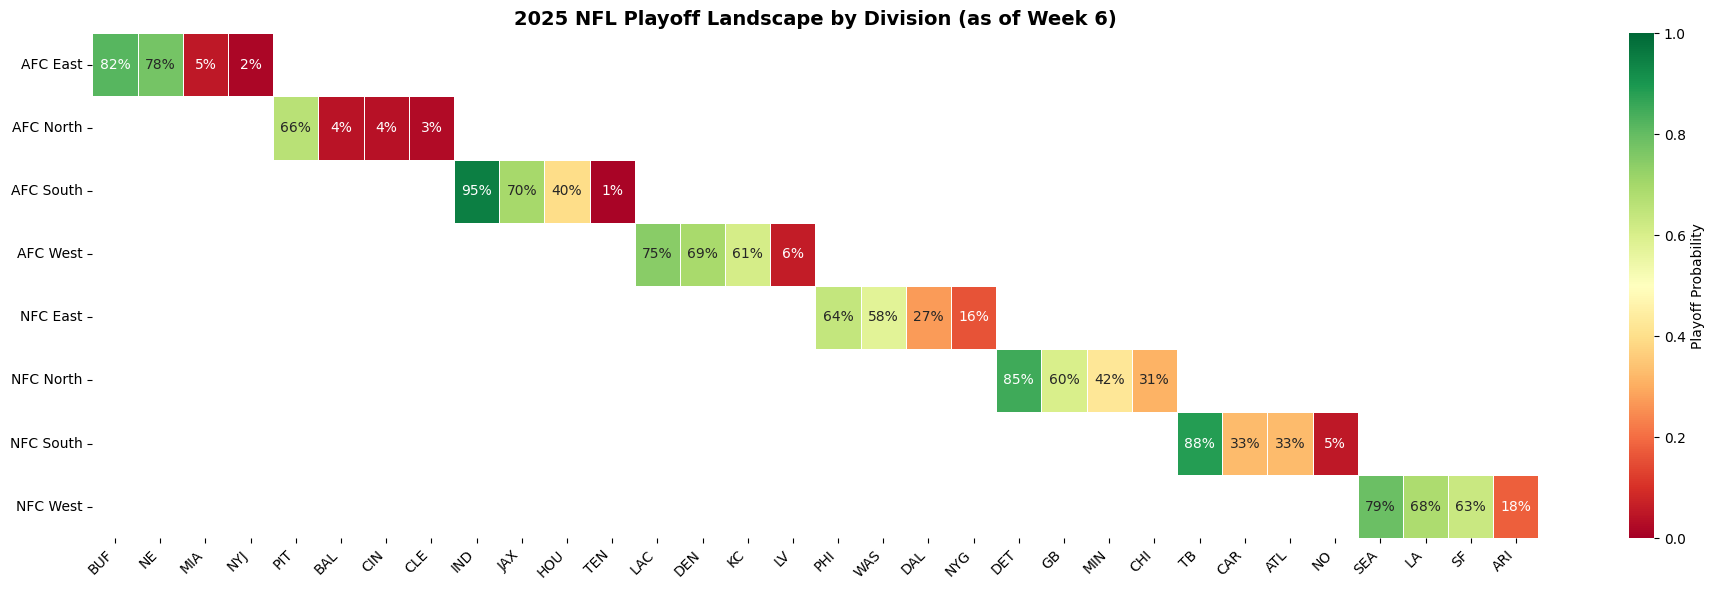

In [157]:
# --- Prep ---
df = inference_data.copy()
df["Prob"] = df["predicted_probability"]

# Desired division order (keeps AFC before NFC)
div_order = [
    "AFC East", "AFC North", "AFC South", "AFC West",
    "NFC East", "NFC North", "NFC South", "NFC West"
]
# Keep only existing divisions
div_order = [d for d in div_order if d in df["Division"].unique()]

# Sort teams within each division by probability (descending)
teams_in_order = []
for d in div_order:
    teams_in_order.extend(
        df.loc[df["Division"] == d]
          .sort_values("Prob", ascending=False)["Team"]
          .tolist()
    )

# --- Pivot table ---
pivot = df.pivot(index="Division", columns="Team", values="Prob")

# Reindex rows and columns (ensures all divisions and teams appear)
pivot = pivot.reindex(index=div_order, columns=teams_in_order)

# Replace NaN with np.nan for masking
mask = pivot.isna()

# --- Plot ---
plt.figure(figsize=(max(14, 0.6 * len(teams_in_order)), 6))
ax = sns.heatmap(
    pivot,
    cmap="RdYlGn",
    vmin=0, vmax=1,
    linewidths=0.5, linecolor="white",
    mask=mask,
    annot=pivot.applymap(lambda x: f"{x:.0%}" if pd.notnull(x) else ""),
    fmt="",
    cbar_kws={"label": "Playoff Probability"}
)

# --- Titles & labels ---
ax.set_title("2025 NFL Playoff Landscape by Division (as of Week 6)", fontsize=14, weight="bold")
ax.set_xlabel("")
ax.set_ylabel("")

# Clean, modern style
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

plt.xticks(rotation=45, ha="right")  # Rotate team labels for readability
plt.tight_layout()
plt.show()

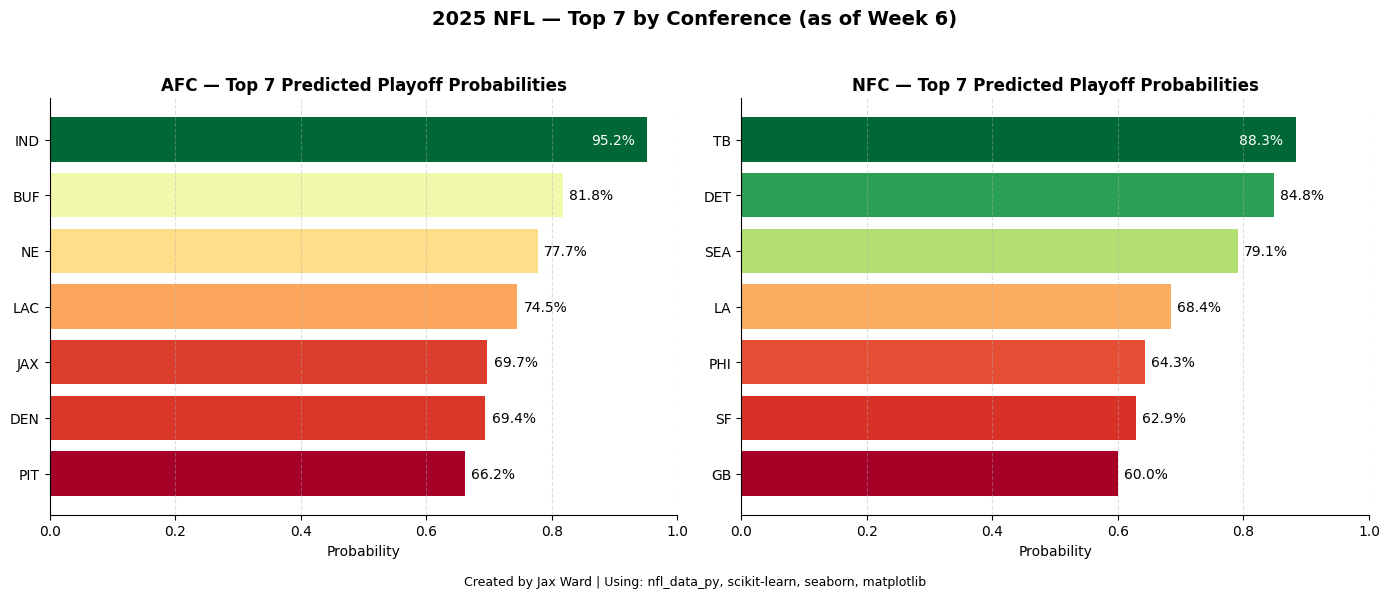

In [161]:
# Get Top 7 per conference
def top7_by_conference(frame, conference):
    top = (frame[frame["Conference"] == conference]
           .nlargest(7, "Prob")
           .sort_values("Prob", ascending=True))  # sort asc for barh (small at bottom, big at top)
    return top

top_afc = top7_by_conference(df, "AFC")
top_nfc = top7_by_conference(df, "NFC")

# Set up colors via a red→yellow→green gradient
def colors_for(values):
    norm = plt.Normalize(values.min(), values.max()) if len(values) else plt.Normalize(0, 1)
    return cm.RdYlGn(norm(values.values))

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

# --- AFC subplot ---
ax = axes[0]
c_afc = colors_for(top_afc["Prob"])
ax.barh(top_afc["Team"], top_afc["Prob"], color=c_afc, edgecolor="none")
for i, (team, p) in enumerate(zip(top_afc["Team"], top_afc["Prob"])):
    # put label inside if high, outside if low
    if p >= 0.85:
        ax.text(p - 0.02, i, f"{p:.1%}", va="center", ha="right", color="white", fontsize=10)
    else:
        ax.text(p + 0.01, i, f"{p:.1%}", va="center", ha="left", fontsize=10)
ax.set_title("AFC — Top 7 Predicted Playoff Probabilities", fontsize=12, fontweight="bold")
ax.set_ylabel("")
ax.set_xlabel("Probability")
ax.grid(axis="x", linestyle="--", alpha=0.4)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

# --- NFC subplot ---
ax = axes[1]
c_nfc = colors_for(top_nfc["Prob"])
ax.barh(top_nfc["Team"], top_nfc["Prob"], color=c_nfc, edgecolor="none")
for i, (team, p) in enumerate(zip(top_nfc["Team"], top_nfc["Prob"])):
    if p >= 0.85:
        ax.text(p - 0.02, i, f"{p:.1%}", va="center", ha="right", color="white", fontsize=10)
    else:
        ax.text(p + 0.01, i, f"{p:.1%}", va="center", ha="left", fontsize=10)
ax.set_title("NFC — Top 7 Predicted Playoff Probabilities", fontsize=12, fontweight="bold")
ax.set_ylabel("")
ax.set_xlabel("Probability")
ax.grid(axis="x", linestyle="--", alpha=0.4)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

# Global styling
fig.suptitle("2025 NFL — Top 7 by Conference (as of Week 6)", fontsize=14, fontweight="bold", y=0.98)
fig.text(0.5, 0.02, "Created by Jax Ward | Using: nfl_data_py, scikit-learn, seaborn, matplotlib",
         ha="center", fontsize=9, color="black")

# X-axis bounds & layout
max_prob = max(df["Prob"].max(), 1.0) if not np.isnan(df["Prob"].max()) else 1.0
axes[0].set_xlim(0, 1.0)
axes[1].set_xlim(0, 1.0)

plt.tight_layout(rect=[0, 0.04, 1, 0.95])
plt.show()